### We have access to a specific bank loan data. We have data about all loans asked to the bank, whether the bank decided to grant it and, finally, whether the borrower managed to repay it. We also have info about the borrower at the moment she is asking for the loan.

### You have to come up with a better strategy to grant loans. Specifically you should: Build a model which is better than the bank model. For simplicity, assume that:

##### If you grant the loan and the it doesn’t get repaid, you lose 1

##### If you grant the loan and the it does get repaid, you gain 1

##### If you don’t grant the loan, you gain 0

#### (1) Using the rules above, compare bank profitability vs your model profitability.

#### (2) Describe the impact of the most important variables on the prediction. Also, focus on the variable “is_employed”, which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why.

#### (3) Are there any other variables, not in the data provided, that you’d have liked to include in the model?

### Load the package would be used

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

[WARNING] H2O requires requests module of version 2.10 or newer. You have version 2.9.1.
You can upgrade to the newest version of the module running from the command line
    $ pip3 install --upgrade requests


### Read in the data set

In [2]:
borrower = pd.read_csv("../Datasets//loan/borrower_table.csv")
loan = pd.read_csv("../Datasets//loan/loan_table.csv")

### Look into dataset

In [3]:
print(borrower.shape)
print(loan.shape)

print(borrower.head)
print(loan.head)

print(borrower.info)
print(loan.info)

print(len(borrower["loan_id"]) == len(pd.unique(borrower["loan_id"])))
print(len(loan["loan_id"]) == len(pd.unique(loan["loan_id"])))

(101100, 12)
(101100, 5)
<bound method NDFrame.head of         loan_id  is_first_loan  fully_repaid_previous_loans  currently_repaying_other_loans  total_credit_card_limit  ...  checking_amount  is_employed  yearly_salary  age  dependent_number
0        289774              1                          NaN                             NaN                     8000  ...             1073            0              0   47                 3
1        482590              0                          1.0                             0.0                     4500  ...             5299            1          13500   33                 1
2        135565              1                          NaN                             NaN                     6900  ...             3422            1          24500   38                 8
3        207797              0                          1.0                             0.0                     1200  ...             3388            0              0   24              

### Data precessing

In [4]:
dat0 = loan.merge(borrower, on = "loan_id", how = "inner")
len(dat0)
print(list(dat0.columns))
dat0.head()

['loan_id', 'loan_purpose', 'date', 'loan_granted', 'loan_repaid', 'is_first_loan', 'fully_repaid_previous_loans', 'currently_repaying_other_loans', 'total_credit_card_limit', 'avg_percentage_credit_card_limit_used_last_year', 'saving_amount', 'checking_amount', 'is_employed', 'yearly_salary', 'age', 'dependent_number']


,loan_id,loan_purpose,date,loan_granted,loan_repaid,...,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,...,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,...,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,...,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,...,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,...,3695,1,34800,31,4


Since the project aims to rebuild the loan granted model, a better outcome variable than the flag “loan_granted” is the flag of “loan_repaid”. Accordingly, we first subset data with granted loans and use the loan_repaid as our binary outcome.

In [5]:
dat = dat0[dat0["loan_granted"] == 1]
print(len(dat))
dat["date"] = pd.to_datetime(dat["date"])

47654


<ipython-input-5-d2131464326a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat["date"] = pd.to_datetime(dat["date"])


### Visulization

#### Should grant by loan purpose

Text(0, 0.5, 'Loan Repaid Rate')

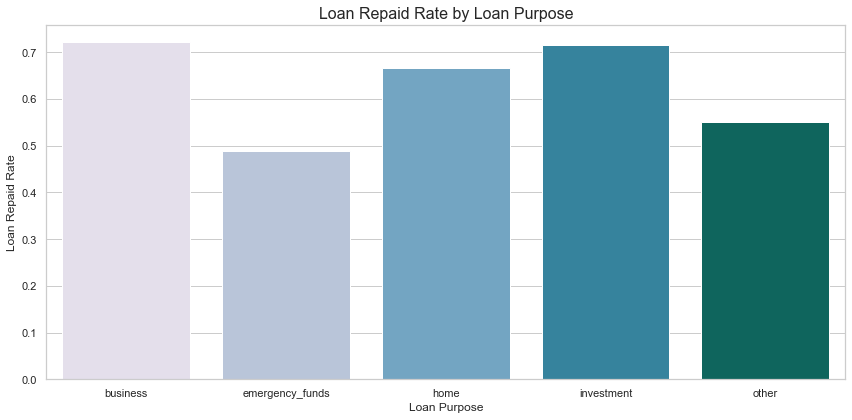

In [6]:
grp_purpose = dat[["loan_purpose", "loan_repaid"]].groupby("loan_purpose").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "loan_purpose", y = "loan_repaid", data = grp_purpose, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Loan Purpose", fontsize = 16)
plt.xlabel("Loan Purpose", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

#### Should grant by if first loan

Text(0, 0.5, 'Loan Repaid Rate')

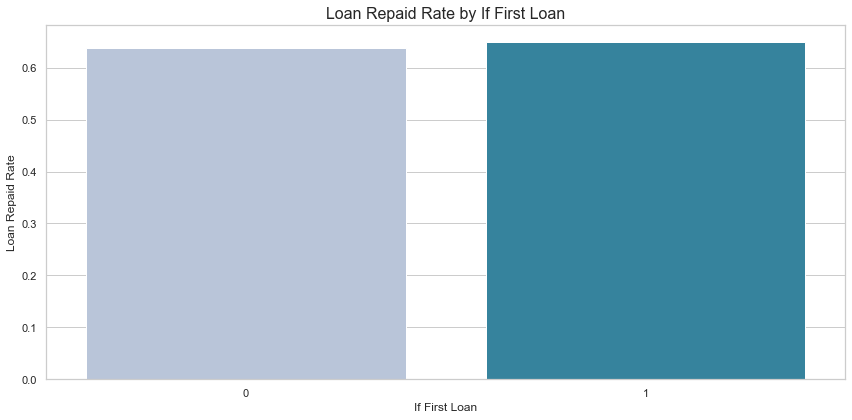

In [7]:
grp_first_loan = dat[["is_first_loan", "loan_repaid"]].groupby("is_first_loan").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "is_first_loan", y = "loan_repaid", data = grp_first_loan, palette = "PuBuGn")
plt.title("Loan Repaid Rate by If First Loan", fontsize = 16)
plt.xlabel("If First Loan", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

#### Should grant by Fully Repaid Previous Loans

Text(0, 0.5, 'Loan Repaid Rate')

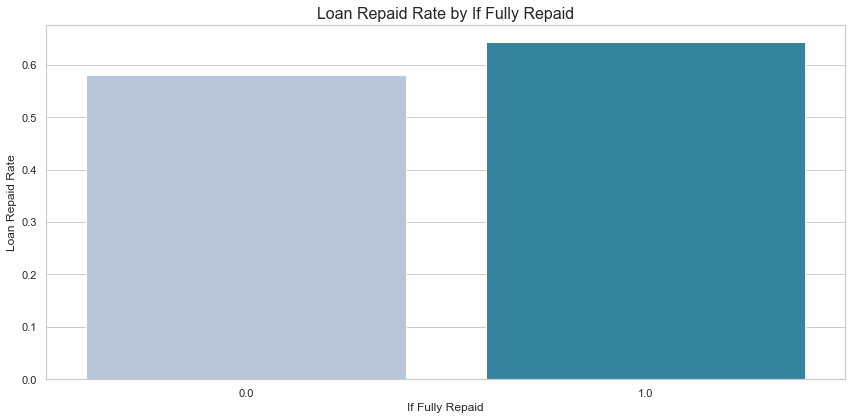

In [8]:
grp_fully_repaid = dat[["fully_repaid_previous_loans", "loan_repaid"]].groupby("fully_repaid_previous_loans").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "fully_repaid_previous_loans", y = "loan_repaid", data = grp_fully_repaid, palette = "PuBuGn")
plt.title("Loan Repaid Rate by If Fully Repaid", fontsize = 16)
plt.xlabel("If Fully Repaid", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

#### Should grant by Currently Repaying Other Loans

Text(0, 0.5, 'Loan Repaid Rate')

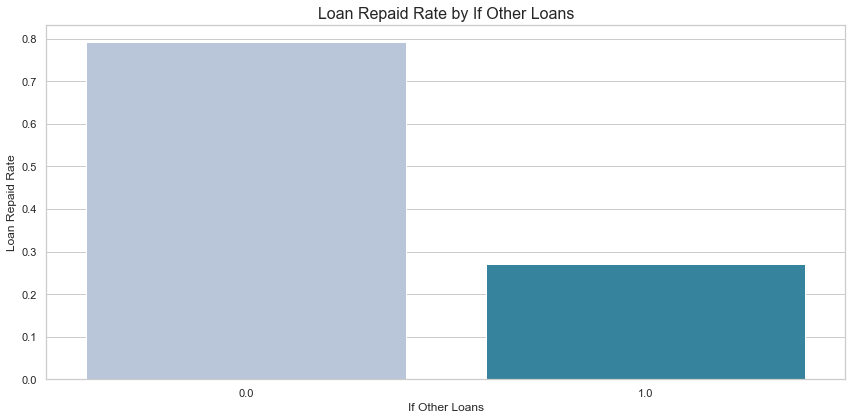

In [9]:
grp_other_loans = dat[["currently_repaying_other_loans", "loan_repaid"]].groupby("currently_repaying_other_loans").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "currently_repaying_other_loans", y = "loan_repaid", data = grp_other_loans, palette = "PuBuGn")
plt.title("Loan Repaid Rate by If Other Loans", fontsize = 16)
plt.xlabel("If Other Loans", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

#### Should grant by Total Credit Card Limit

Text(0, 0.5, 'Loan Repaid Rate')

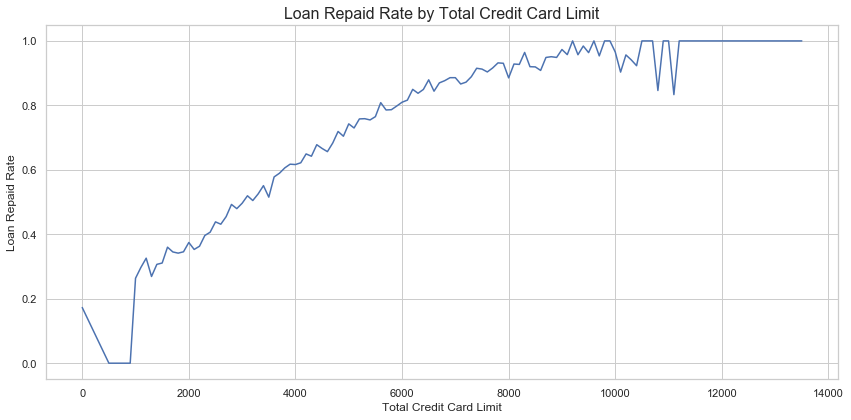

In [10]:
grp_card_limit = dat[["total_credit_card_limit", "loan_repaid"]].groupby("total_credit_card_limit").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "total_credit_card_limit", y = "loan_repaid", data = grp_card_limit, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Total Credit Card Limit", fontsize = 16)
plt.xlabel("Total Credit Card Limit", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

#### Should grant by Average Percentage Credit Card Limit Used Last Year

Text(0, 0.5, 'Loan Repaid Rate')

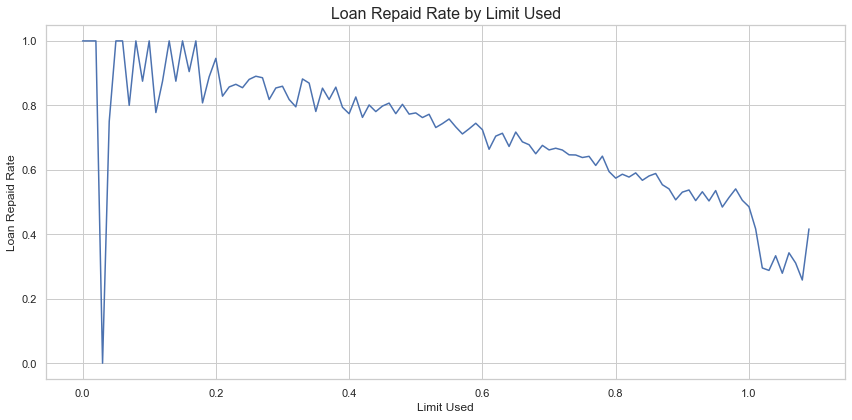

In [11]:
grp_limit_used = dat[["avg_percentage_credit_card_limit_used_last_year", "loan_repaid"]].groupby("avg_percentage_credit_card_limit_used_last_year").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "avg_percentage_credit_card_limit_used_last_year", y = "loan_repaid", data = grp_limit_used, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Limit Used", fontsize = 16)
plt.xlabel("Limit Used", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

#### Should grant by Saving Amount

Text(0, 0.5, 'Loan Repaid Rate')

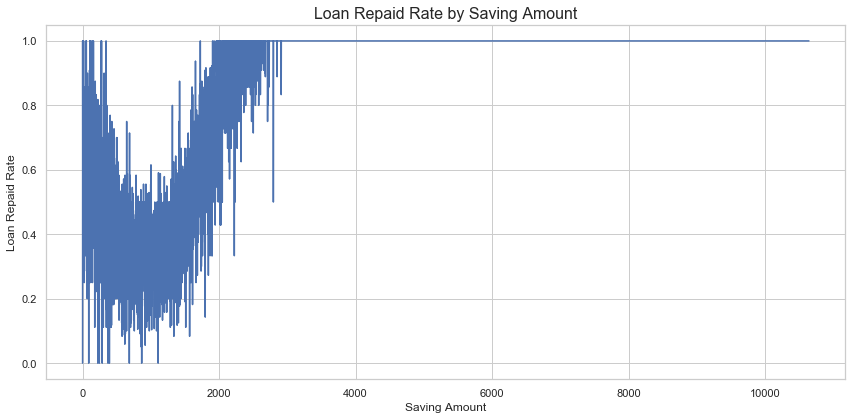

In [12]:
grp_saving = dat[["saving_amount", "loan_repaid"]].groupby("saving_amount").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "saving_amount", y = "loan_repaid", data = grp_saving, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Saving Amount", fontsize = 16)
plt.xlabel("Saving Amount", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

#### Should grant by Checking Amount

Text(0, 0.5, 'Loan Repaid Rate')

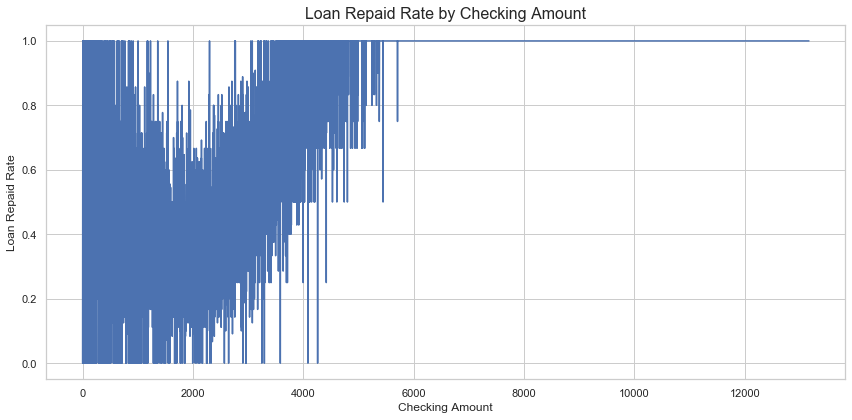

In [13]:
grp_checking = dat[["checking_amount", "loan_repaid"]].groupby("checking_amount").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "checking_amount", y = "loan_repaid", data = grp_checking, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Checking Amount", fontsize = 16)
plt.xlabel("Checking Amount", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

### Should grant by If Employed

Text(0, 0.5, 'Loan Repaid Rate')

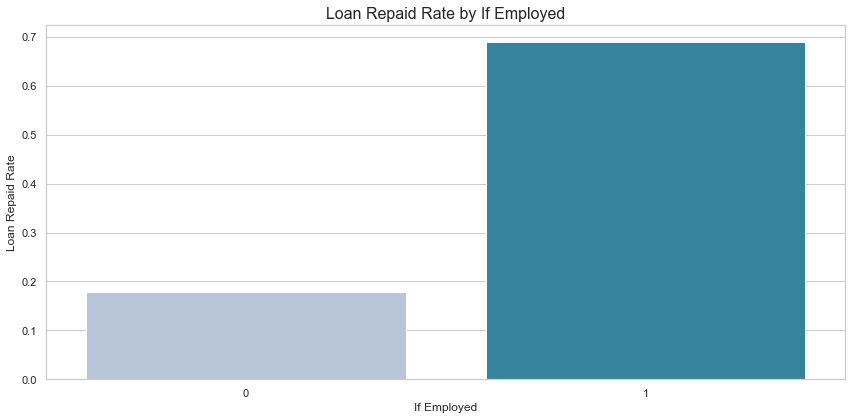

In [14]:
grp_is_employed = dat[["is_employed", "loan_repaid"]].groupby("is_employed").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "is_employed", y = "loan_repaid", data = grp_is_employed, palette = "PuBuGn")
plt.title("Loan Repaid Rate by If Employed", fontsize = 16)
plt.xlabel("If Employed", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

### Should grant by Yearly Salary

Text(0, 0.5, 'Loan Repaid Rate')

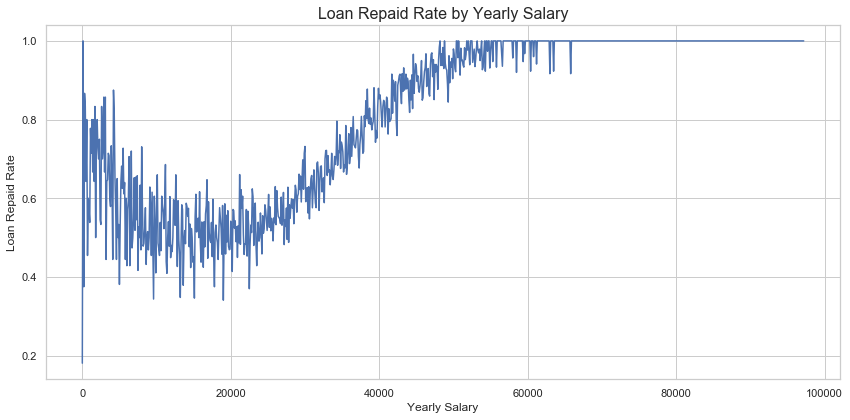

In [15]:
grp_salary = dat[["yearly_salary", "loan_repaid"]].groupby("yearly_salary").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "yearly_salary", y = "loan_repaid", data = grp_salary, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Yearly Salary", fontsize = 16)
plt.xlabel("Yearly Salary", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

### Should grant by Age

Text(0, 0.5, 'Loan Repaid Rate')

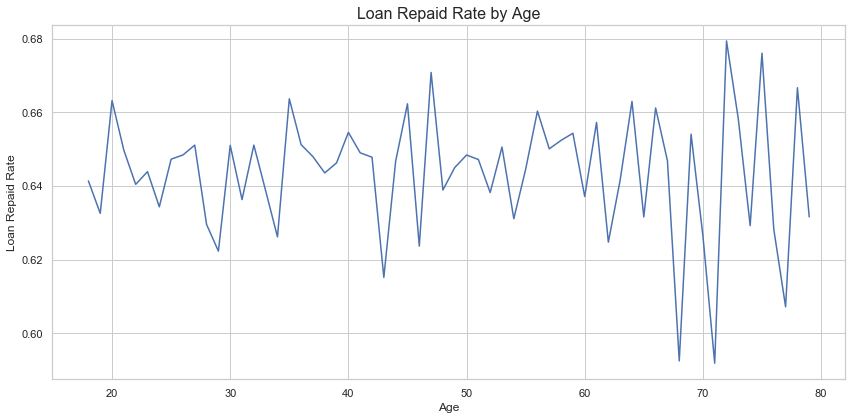

In [16]:
grp_age = dat[["age", "loan_repaid"]].groupby("age").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "age", y = "loan_repaid", data = grp_age, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Age", fontsize = 16)
plt.xlabel("Age", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

### Should grant by Dependent Number

Text(0, 0.5, 'Loan Repaid Rate')

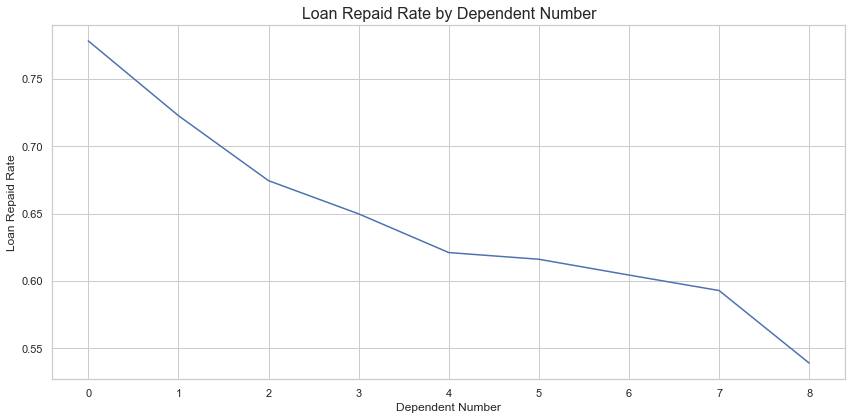

In [17]:
grp_dependent = dat[["dependent_number", "loan_repaid"]].groupby("dependent_number").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "dependent_number", y = "loan_repaid", data = grp_dependent, palette = "PuBuGn")
plt.title("Loan Repaid Rate by Dependent Number", fontsize = 16)
plt.xlabel("Dependent Number", fontsize = 12)
plt.ylabel("Loan Repaid Rate", fontsize = 12)

### Build A Classifier 

In [18]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()

dat_h2o = H2OFrame(dat)
dat_h2o["is_first_loan"] = dat_h2o["is_first_loan"].asfactor()
dat_h2o["loan_purpose"] = dat_h2o["loan_purpose"].asfactor()
dat_h2o["is_first_loan"] = dat_h2o["is_first_loan"].asfactor()
dat_h2o["fully_repaid_previous_loans"] = dat_h2o["fully_repaid_previous_loans"].asfactor()
dat_h2o["currently_repaying_other_loans"] = dat_h2o["currently_repaying_other_loans"].asfactor()
dat_h2o["is_employed"] = dat_h2o["is_employed"].asfactor()

dat_h2o.summary()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.1" 2019-10-15; Java(TM) SE Runtime Environment (build 13.0.1+9); Java HotSpot(TM) 64-Bit Server VM (build 13.0.1+9, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpksov851a
  JVM stdout: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpksov851a/h2o_jinliu_started_from_python.out
  JVM stderr: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpksov851a/h2o_jinliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_jinliu_b5b6lp
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
type,int,enum,time,int,int,enum,enum,enum,int,real,int,int,enum,int,int,int
mins,37.0,,1325462400000.0,1.0,0.0,,,,0.0,0.0,0.0,0.0,,0.0,18.0,0.0
mean,500187.7754018539,,1340950269929.0757,1.0,0.644353044865069,,,,4527.848659084232,0.7000911210455354,2022.3665799303362,3499.1605951231963,,29245.991941914694,41.52465690183363,3.7524447055860777
maxs,999968.0,,1356652800000.0,1.0,1.0,,,,13500.0,1.09,10641.0,13165.0,,97200.0,79.0,8.0
sigma,288925.68200923793,,9074295414.293694,0.0,0.47871390977863776,,,,1975.1270160617476,0.177728809326715,1493.4103028291925,2155.1283039834466,,16286.51239529687,12.817586666159992,2.621350611703775
zeros,0,,0,0,16948,,,,903,2,2,2,,4306,0,1768
missing,0,0,0,0,0,0,0,0,0,903,0,0,0,0,0,0
0,580653.0,other,2012-06-27 00:00:00,1.0,1.0,0,1.0,0.0,5400.0,0.52,3345.0,2764.0,1,15800.0,58.0,4.0
1,172419.0,business,2012-05-21 00:00:00,1.0,0.0,1,nan,nan,2900.0,0.76,1050.0,3695.0,1,34800.0,31.0,4.0
2,780070.0,business,2012-03-14 00:00:00,1.0,1.0,0,1.0,0.0,7800.0,0.3,4206.0,4368.0,1,51100.0,51.0,2.0


In [19]:
index = dat_h2o["loan_repaid"].stratified_split(test_frac = 0.34, seed = 2019)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X = ["is_first_loan", "fully_repaid_previous_loans", "currently_repaying_other_loans", "total_credit_card_limit",
     "avg_percentage_credit_card_limit_used_last_year", "saving_amount", "checking_amount", "is_employed",
     "yearly_salary", "age", "dependent_number"]
Y = "loan_repaid"

In [20]:
RF = H2ORandomForestEstimator(balance_classes = False, ntrees = 100, max_depth = 20, 
                              mtries = -1, seed = 2019, score_each_iteration = True)
RF.train(x = X, y = Y, training_frame = train_dat)

drf Model Build progress: |███████████████████████████████████████████████| 100%


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5762
           1       0.95      0.93      0.94     10440

    accuracy                           0.92     16202
   macro avg       0.91      0.92      0.91     16202
weighted avg       0.92      0.92      0.92     16202



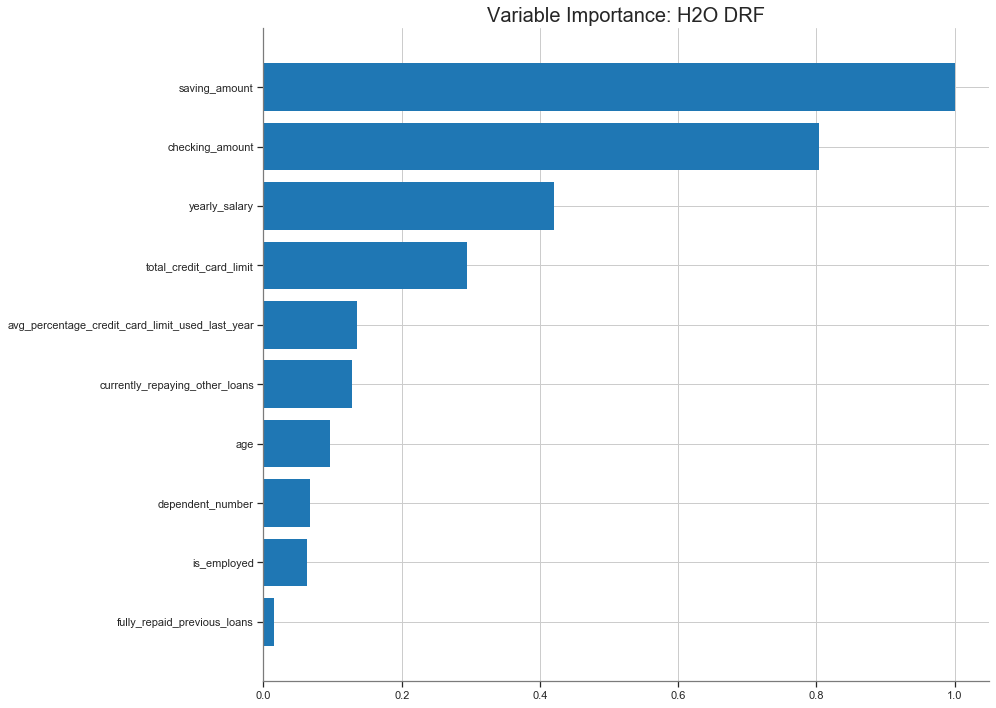

In [21]:
train_true = train_dat.as_data_frame()["loan_repaid"].values
test_true = test_dat.as_data_frame()["loan_repaid"].values
train_pred = RF.predict(train_dat).as_data_frame()["predict"].values
test_pred = RF.predict(test_dat).as_data_frame()["predict"].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)
print(classification_report(y_true=test_true, y_pred = (test_pred > 0.5).astype(int)))
RF.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/model/model_base.py:1186: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'is_first_loan'


,is_first_loan,mean_response,stddev_response,std_error_mean_response
0,0,0.647118,0.424688,0.002395
1,1,0.643061,0.428937,0.002419



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'fully_repaid_previous_loans'


,fully_repaid_previous_loans,mean_response,stddev_response,std_error_mean_response
0,0.0,0.643623,0.416021,0.002346
1,1.0,0.650454,0.420354,0.002370
2,nan,0.640407,0.427483,0.002410



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'currently_repaying_other_loans'


,currently_repaying_other_loans,mean_response,stddev_response,std_error_mean_response
0,0.0,0.677669,0.392787,0.002215
1,1.0,0.562100,0.427602,0.002411
2,nan,0.654742,0.412215,0.002324



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'total_credit_card_limit'


,total_credit_card_limit,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.486971,0.368295,0.002077
1,710.526316,0.474903,0.362382,0.002043
2,1421.052632,0.555356,0.420214,0.002369
3,2131.578947,0.576860,0.428146,0.002414
4,2842.105263,0.599922,0.421676,0.002378
5,3552.631579,0.622627,0.414959,0.002340
6,4263.157895,0.647118,0.402245,0.002268
7,4973.684211,0.671366,0.386622,0.002180
8,5684.210526,0.694979,0.370322,0.002088
9,6394.736842,0.730036,0.339840,0.001916



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'avg_percentage_credit_card_limit_used_last_year'


,avg_percentage_credit_card_limit_used_last_year,mean_response,stddev_response,std_error_mean_response
0,0.020000,0.711212,0.327534,0.001847
1,0.076316,0.712860,0.328736,0.001854
2,0.132632,0.713316,0.328494,0.001852
3,0.188947,0.716766,0.331358,0.001868
4,0.245263,0.710107,0.345923,0.001951
5,0.301579,0.703481,0.356743,0.002012
6,0.357895,0.695487,0.367878,0.002074
7,0.414211,0.687881,0.377622,0.002129
8,0.470526,0.680951,0.385918,0.002176
9,0.526842,0.674112,0.392775,0.002215



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'saving_amount'


,saving_amount,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.608860,0.346935,0.001956
1,560.052632,0.543240,0.400284,0.002257
2,1120.105263,0.536831,0.404027,0.002278
3,1680.157895,0.601943,0.370349,0.002088
4,2240.210526,0.848894,0.218311,0.001231
5,2800.263158,0.966589,0.068419,0.000386
6,3360.315789,0.975761,0.053081,0.000299
7,3920.368421,0.976509,0.052121,0.000294
8,4480.421053,0.976924,0.051240,0.000289
9,5040.473684,0.977288,0.050117,0.000283



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'checking_amount'


,checking_amount,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.589633,0.372698,0.002102
1,693.842105,0.565148,0.402253,0.002268
2,1386.684211,0.552200,0.415022,0.002340
3,2079.526316,0.555473,0.415054,0.002340
4,2772.368421,0.583290,0.397313,0.002240
5,3465.210526,0.662144,0.350925,0.001979
6,4158.052632,0.784851,0.271849,0.001533
7,4850.894737,0.890465,0.171659,0.000968
8,5543.736842,0.962423,0.070617,0.000398
9,6236.578947,0.968801,0.058037,0.000327



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'is_employed'


,is_employed,mean_response,stddev_response,std_error_mean_response
0,0,0.581278,0.419299,0.002364
1,1,0.656275,0.417928,0.002357



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'yearly_salary'


,yearly_salary,mean_response,stddev_response,std_error_mean_response
0,0.000000,0.604068,0.390596,0.002202
1,5115.789474,0.608101,0.408894,0.002306
2,10231.578947,0.602395,0.419259,0.002364
3,15347.368421,0.601933,0.421374,0.002376
4,20463.157895,0.602263,0.422555,0.002383
5,25578.947368,0.614173,0.418507,0.002360
6,30694.736842,0.632236,0.405122,0.002284
7,35810.526316,0.669413,0.375417,0.002117
8,40926.315789,0.721320,0.339099,0.001912
9,46042.105263,0.775110,0.289539,0.001633



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'age'


,age,mean_response,stddev_response,std_error_mean_response
0,18.000000,0.647900,0.403944,0.002278
1,21.210526,0.646203,0.408344,0.002303
2,24.421053,0.645799,0.414070,0.002335
3,27.631579,0.644112,0.419962,0.002368
4,30.842105,0.644063,0.421593,0.002377
5,34.052632,0.644989,0.422613,0.002383
6,37.263158,0.645789,0.422870,0.002384
7,40.473684,0.646307,0.422219,0.002381
8,43.684211,0.644584,0.423086,0.002386
9,46.894737,0.643778,0.423024,0.002385



PartialDependence: Partial Dependence Plot of model DRF_model_python_1578353910138_1 on column 'dependent_number'


,dependent_number,mean_response,stddev_response,std_error_mean_response
0,0.0,0.674390,0.387951,0.002188
1,1.0,0.659208,0.410395,0.002314
2,2.0,0.653319,0.415635,0.002344
3,3.0,0.646357,0.419223,0.002364
4,4.0,0.641397,0.420325,0.002370
5,5.0,0.638201,0.421384,0.002376
6,6.0,0.636122,0.420817,0.002373
7,7.0,0.632146,0.420781,0.002373
8,8.0,0.627810,0.423045,0.002385


[, , , , , , , , , , ]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


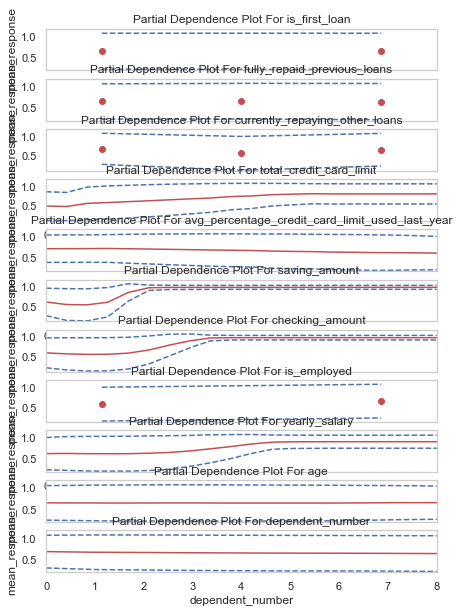

In [22]:
RF.partial_plot(data = train_dat, cols = ["is_first_loan", "fully_repaid_previous_loans", "currently_repaying_other_loans", "total_credit_card_limit",
     "avg_percentage_credit_card_limit_used_last_year", "saving_amount", "checking_amount", "is_employed",
     "yearly_salary", "age", "dependent_number"], plot = True)

#### (1) Using the rules above, compare bank profitability vs your model profitability.

In [23]:
#### Model profitability
prob = np.concatenate([train_pred, test_pred])
cate = prob > 0.5
profit_model = cate * dat["loan_repaid"]

In [24]:
#### Bank profitability
dat0["flag"] = 0
dat0.loc[dat0.loan_repaid == 1.0, "flag"] = 1
dat0.loc[(dat0.loan_repaid == 0.0) & (dat0.loan_granted == 1), "flag"] = -1

In [25]:
print(profit_model.sum())
print(dat0["flag"].sum())

19635.0
13758


#### (2) Describe the impact of the most important variables on the prediction. Also, focus on the variable “is_employed”, which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why.

See R solution.

#### (3) Are there any other variables, not in the data provided, that you’d have liked to include in the model?

See R solution.